In [2]:
import torch
import torch.optim as opt
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
size = 32

transform=torchvision.transforms.Compose(
        [torchvision.transforms.Resize(32), torchvision.transforms.ToTensor()]
    )
trainData = torchvision.datasets.MNIST('./data/', download=True, transform=transform, train=True)

trainLoader = torch.utils.data.DataLoader(trainData, shuffle=True, batch_size=size)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
dataIter = iter(trainLoader)

imgs, labels = dataIter.next()

In [5]:
imgs.shape

torch.Size([32, 1, 32, 32])

In [6]:
def imshow(imgs):
    imgs = torchvision.utils.make_grid(imgs)
    npimgs = imgs.numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimgs, (1,2,0)), cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [7]:
Z_dim = 100
H_dim = 128
X_dim = imgs.view(imgs.size(0), -1).size(1)

print(Z_dim, H_dim, X_dim)

device = 'cuda'

100 128 1024


In [8]:
f_map = 32 
n_out = 1  

In [9]:

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(Z_dim, f_map * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(f_map * 8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(f_map * 8, f_map * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(f_map * 4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(f_map * 4, f_map * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(f_map * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(f_map * 2, n_out, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(n_out, f_map, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(f_map, f_map * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(f_map * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(f_map * 2, f_map * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(f_map * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(f_map * 4, n_out, 4, 2, 1, bias=False),
            nn.Flatten(),
            nn.Linear(4, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [12]:
D = Discriminator().to(device)
D.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=4, out_features=1, bias=True)
    (11): Sigmoid()
  )
)

In [13]:
G = Generator().to(device)
G.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)

In [14]:
lr = 1e-3

g_opt = opt.Adam(G.parameters(), lr=lr)
d_opt = opt.Adam(D.parameters(), lr=lr)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:0,   G_loss:7.744770189332962,    D_loss:0.16192713449443885


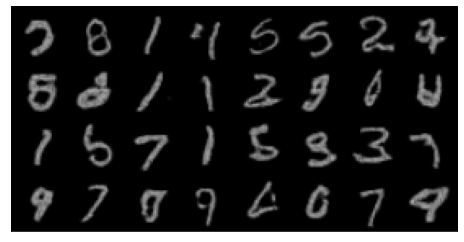

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:1,   G_loss:7.515614776674907,    D_loss:0.13988196466432032


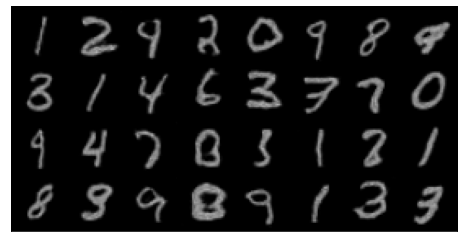

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:2,   G_loss:7.510471552562714,    D_loss:0.13593936096431766


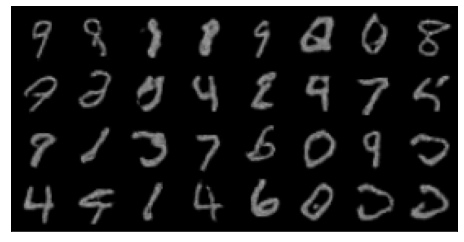

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:3,   G_loss:7.4739642339706425,    D_loss:0.16755470688107987


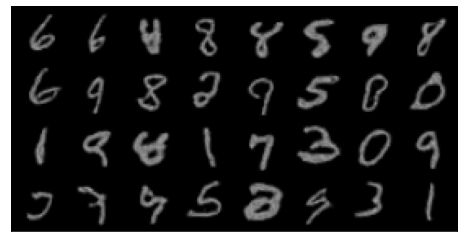

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:4,   G_loss:7.417487776748339,    D_loss:0.15296107329115816


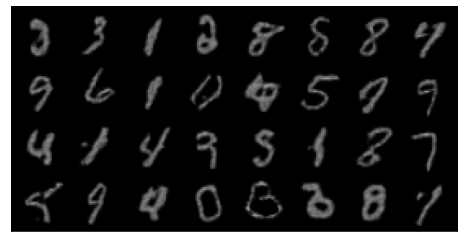

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:5,   G_loss:7.208364565181732,    D_loss:0.14886943986334372


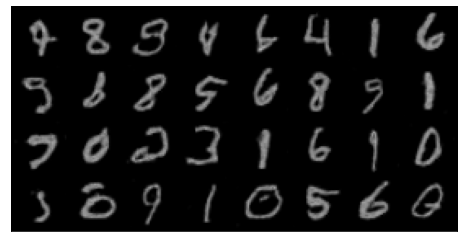

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:6,   G_loss:7.222188891156515,    D_loss:0.13575202774484643


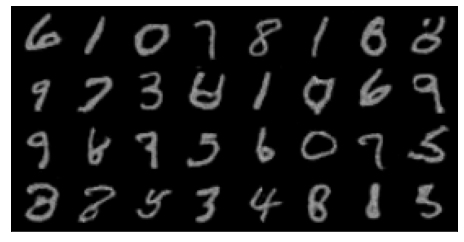

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:7,   G_loss:7.573721469402313,    D_loss:0.17648301817087533


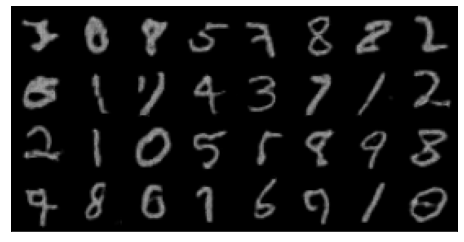

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:8,   G_loss:7.149917194604874,    D_loss:0.16467792399208991


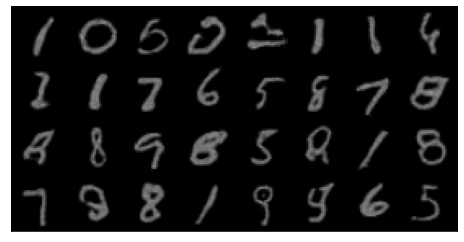

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:9,   G_loss:7.517347827847798,    D_loss:0.14900436417255744


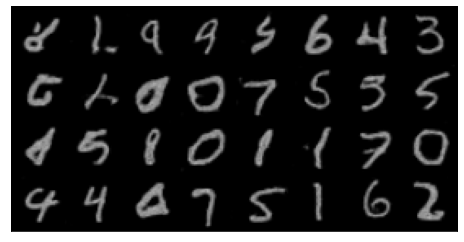

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:10,   G_loss:7.2988573399146395,    D_loss:0.11138745517995122


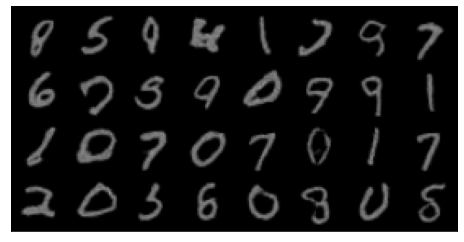

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:11,   G_loss:7.484963913297653,    D_loss:0.17939809569597323


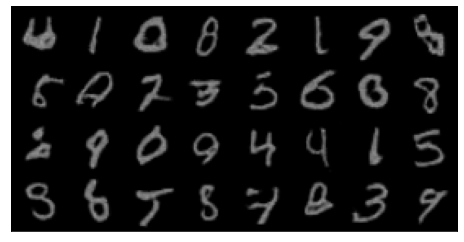

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:12,   G_loss:7.111093338664372,    D_loss:0.17228616548397888


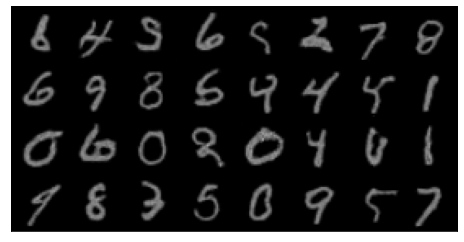

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:13,   G_loss:6.972208928712209,    D_loss:0.1726859129715711


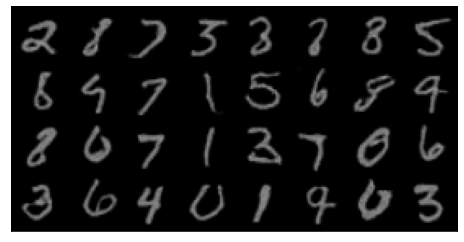

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:14,   G_loss:7.2926518902460735,    D_loss:0.15753196466558925


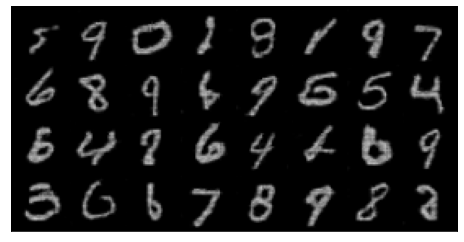

In [17]:
for epoch in range(15):
    G_loss_run = 0.0
    D_loss_run = 0.0
    for i, data in enumerate(trainLoader):
        X, _ = data
        X = X.to(device)
        size = X.size(0)
        
        one_labels = torch.ones(size, 1).to(device)
        zero_labels = torch.zeros(size, 1).to(device)
        
        z = torch.randn(size, Z_dim, 1, 1).to(device)

        D_real = D(X)
        D_fake = D(G(z))
        
        D_real_loss = F.binary_cross_entropy(D_real, one_labels)
        D_fake_loss = F.binary_cross_entropy(D_fake, zero_labels)
        D_loss = D_real_loss + D_fake_loss
        
        d_opt.zero_grad()
        D_loss.backward()
        d_opt.step()
        
        z = torch.randn(size, Z_dim, 1, 1).to(device)
        D_fake = D(G(z))
        G_loss = F.binary_cross_entropy(D_fake, one_labels)
        
        g_opt.zero_grad()
        G_loss.backward()
        g_opt.step()
        
        G_loss_run += G_loss.item()
        D_loss_run += D_loss.item()
        
    print('Epoch:{},   G_loss:{},    D_loss:{}'.format(epoch, G_loss_run/(i+1), D_loss_run/(i+1)))
    
    samples = G(z).detach()
    samples = samples.view(samples.size(0), 1, 32, 32).cpu()
    imshow(samples)


In [ ]:
z_te = torch.randn(32, 100, 1, 1).to(device)